# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### Answer

As per the paper linked, the researchers performed 3 iterations of CRISP-DM 

1. Iteration 1 --> 79354 contacts with 6499 successful conversions to deposit (8% success rate)
2. Iteration 2 --> 55817 contacts with 6499 successful deposits (11.6% success rate)
3. Iteration 3 --> 45211 contacts with 5289 successful deposits (11.7% success rate)

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [32]:
# All imports to be listed here. Remember to run this cell everytime a new one is added.

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
df_bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
# Helper function to get all details about the dataframe
def display_column_info(df):
  """
  Given a dataframe df, returns the statistics of this dataframe
  """

  # check if input parameter is actually a df
  if not isinstance(df, pd.DataFrame):
    prtint("Input parameter is not a dataframe")
    return None

  column_names = []
  data_types = []
  nan_count_list = []
  nan_percentage_list = []
  unique_count_list = []
  data_range_list = []

  for column in df.columns:
    column_names.append(column)
    data_types.append(df[column].dtype)
    nan_count = ((df[column] == 0).sum()) if pd.api.types.is_numeric_dtype(df[column]) else df[column].isnull().sum()
    nan_count_list.append(nan_count)
    nan_percentage_list = (nan_count / len(df)) * 100
    unique_count_list.append(df[column].nunique())

    if pd.api.types.is_numeric_dtype(df[column]):
      min_val = df[column].min()
      max_val = df[column].max()
      data_range_list.append(f"{min_val} - {max_val}")
    else:
      data_range_list.append(df[column].unique())

  column_info_df = pd.DataFrame(
      {'column_name': column_names,
       'data_type': data_types,
       'nan_or_zero_count': nan_count_list,
       'nan_or_zero_percentage': nan_percentage_list,
       'unique_count': unique_count_list,
       'data_range': data_range_list
      })

  column_info_df.set_index('column_name', inplace=True)
  rows, cols = df.shape
  print("Number of rows: ", rows)
  print("Number of columns: ", cols)
  display(column_info_df)
  return None
    

In [5]:
display_column_info(df_bank)

Number of rows:  41188
Number of columns:  21


,data_type,nan_or_zero_count,nan_or_zero_percentage,unique_count,data_range
column_name,,,,,
age,int64,0,0.0,78,17 - 98
job,object,0,0.0,12,"[housemaid, services, admin., blue-collar, tec..."
marital,object,0,0.0,4,"[married, single, divorced, unknown]"
education,object,0,0.0,8,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
default,object,0,0.0,3,"[no, unknown, yes]"
housing,object,0,0.0,3,"[no, yes, unknown]"
loan,object,0,0.0,3,"[no, yes, unknown]"
contact,object,0,0.0,2,"[telephone, cellular]"
month,object,0,0.0,10,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."


In [6]:
df_bank.query("duration == 0")

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
6251,39,admin.,married,high.school,no,yes,no,telephone,may,tue,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
23031,59,management,married,university.degree,no,yes,no,cellular,aug,tue,...,10,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
28063,53,blue-collar,divorced,high.school,no,yes,no,cellular,apr,fri,...,3,999,0,nonexistent,-1.8,93.075,-47.1,1.479,5099.1,no
33015,31,blue-collar,married,basic.9y,no,no,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no


In [7]:
# since there are only 4 data samples with duration == 0
# and for all these samples the target variable 'y' is 'no'
# we can safely drop this samples

df_bank_filtered = df_bank.query("duration != 0")

display_column_info(df_bank_filtered)

Number of rows:  41184
Number of columns:  21


,data_type,nan_or_zero_count,nan_or_zero_percentage,unique_count,data_range
column_name,,,,,
age,int64,0,0.0,78,17 - 98
job,object,0,0.0,12,"[housemaid, services, admin., blue-collar, tec..."
marital,object,0,0.0,4,"[married, single, divorced, unknown]"
education,object,0,0.0,8,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
default,object,0,0.0,3,"[no, unknown, yes]"
housing,object,0,0.0,3,"[no, yes, unknown]"
loan,object,0,0.0,3,"[no, yes, unknown]"
contact,object,0,0.0,2,"[telephone, cellular]"
month,object,0,0.0,10,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."


In [8]:
df_bank_filtered['y'].value_counts()

y
no     36544
yes     4640
Name: count, dtype: int64

#### Answer

The provided bank data has
1. 41,188 rows
2. 21 columns with 20 features and 1 target variable 'y'
3. Target variable only has 2 unique values, 'yes' and 'no'
4. There are no NaN values
5. The column 'previous' has 35563 instances with value 0, which should not be considered as NaN / invalid value. It is highly possible that a lot of contacts were only done once.
6. The 'duration' column had 4 values with 0, it is almost 0.009% of data. Also the target variable 'y' for all of these is "no". so decided to drop these samples.
7. Now the new data is 41184 samples, with 4640 yes values, 11.2% success rate


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Answer

The Business Objective is:
  - Given the data, build a prediction model to identify if a new customer will choose to opt for a deposit (success rate) if contacted. Also understand what can be changed/improved to enhance the success rate of customers opting for a long term deposit

In [9]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [10]:
# Create input dataframe X and target variable series y
X = df_bank_filtered.drop('y', axis=1)
y = df_bank_filtered['y']

print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

Shape of X (features): (41184, 20)
Shape of y (target): (41184,)


In [11]:
# the target variable 'y' is categorical, convert it to numerical with LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Original 'y' unique values:", y.unique())
print("encoded 'y' values:", y_encoded)

Original 'y' unique values: ['no' 'yes']
encoded 'y' values: [0 0 0 ... 0 1 0]


In [12]:
# identify the numerical and categorical features, so we can do a column transformation
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [13]:
# Create a ColumnTransformer
#    StandardScaler --> for numerical values
#.   OneHotEncoder --> for categorical values
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler_numerical', StandardScaler(), numerical_features),
        ('onehot_categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
)

X_preprocessed = preprocessor.fit_transform(X)

print("Shape of preprocessed X:", X_preprocessed.shape)
print("Preprocessed features created.")

Shape of preprocessed X: (41184, 63)
Preprocessed features created.


#### Answer 
1. Created input features dataframe X by dropping target variable 'y' from df_bank_filtered
2. Create target variable series y by selecting only target variable from df_bank_filtered
3. The Target variable is string (Categorical) with values yes and no, convert it to numerical with LabelEncoder
4. Identify numerical and categorical features
5. For numerical features --> Perform standardScaler
6. For categorical features --> Perform OneHotEncocoding


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [14]:
# Use random_state=42 so results are reproducible now and for grading of assignment
# The outcome (target variable) is highly imbalanced, so using stratify to make sure equal proportion
# of the target variable are available in train and test sets. 

X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nTarget distribution in original data:\n", pd.Series(y_encoded).value_counts(normalize=True))
print("\nTarget distribution in training set:\n", pd.Series(y_train).value_counts(normalize=True))
print("\nTarget distribution in test set:\n", pd.Series(y_test).value_counts(normalize=True))

Shape of X_train: (32947, 63)
Shape of X_test: (8237, 63)
Shape of y_train: (32947,)
Shape of y_test: (8237,)

Target distribution in original data:
 0    0.887335
1    0.112665
Name: proportion, dtype: float64

Target distribution in training set:
 0    0.887334
1    0.112666
Name: proportion, dtype: float64

Target distribution in test set:
 0    0.887338
1    0.112662
Name: proportion, dtype: float64


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [15]:

# Calculate the count of each class in the training set
class_counts = pd.Series(y_train).value_counts()

# Identify the majority class and its count
majority_class = class_counts.idxmax()
majority_count = class_counts.max()

# Calculate the baseline accuracy
baseline_accuracy = majority_count / len(y_train)

print(f"Majority class in training set: {majority_class}")
print(f"Count of majority class: {majority_count}")
print(f"Total samples in training set: {len(y_train)}")
print(f"Baseline accuracy (by predicting majority class): {baseline_accuracy * 100:4f}%")

Majority class in training set: 0
Count of majority class: 29235
Total samples in training set: 32947
Baseline accuracy (by predicting majority class): 88.733420%


#### Answer

From our data exploration, we already know that the output(target) is imbalanced. To additionaly make sure, we re-calculate the majority class on the training set. 

The simplest model we can make is to just predict the majority class. In this specific case, even if we always blindly predict the target as 'No', this method will result in a **88%** accuracy of prediction.

**Any models that we create should at least be better than 88% accuracy of the basic always "No" predicting model"**

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [16]:
# Initialize the Logistic Regression model
logistic_reg_model = LogisticRegression(random_state=42)

# Fit the model to the training data
logistic_reg_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


### Problem 9: Score the Model

What is the accuracy of your model?

In [17]:
# Calculate training accuracy
train_accuracy = logistic_reg_model.score(X_train, y_train)

# Calculate testing accuracy
test_accuracy = logistic_reg_model.score(X_test, y_test)

print(f"Logistic Regression Training Accuracy: {train_accuracy:.4f}")
print(f"Logistic Regression Testing Accuracy: {test_accuracy:.4f}")

Logistic Regression Training Accuracy: 0.9111
Logistic Regression Testing Accuracy: 0.9137


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [18]:
# First create the Dataframe as above 
df_model_comparison = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
df_model_comparison

,Model,Train Time,Train Accuracy,Test Accuracy


In [19]:
# Helper function to perform model training and computing accuracy score 

def train_and_evaluate_model(model, model_name):
    # Was not able to access the global variable without this. Found solution in google 
    global X_train
    global X_test
    global y_train
    global y_test 
    global df_model_comparison
    
    # Not sure if all models compute the timing, doing it here to keep it consistent for all models.
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    train_time = end_time - start_time 

    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    # Create a dictionary for the current model's results
    results = {
        'Model': model_name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    }

    # Append to the comparison DataFrame
    df_model_comparison = pd.concat([df_model_comparison, pd.DataFrame([results])], ignore_index=True)
    display(df_model_comparison)

In [20]:
# Add Logistic regression model (from problem 8 an 9) to results 

train_and_evaluate_model(logistic_reg_model, "Logistic Regresion")

/var/folders/2d/_3zzzy7j0wv3swr8rqvqlnbm0000gn/T/ipykernel_62143/2353434814.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model_comparison = pd.concat([df_model_comparison, pd.DataFrame([results])], ignore_index=True)


,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regresion,0.110792,0.911069,0.913682


In [21]:
# Create, train and evaluate the k-nearest neighbors model
knn_model = KNeighborsClassifier()
train_and_evaluate_model(knn_model, "k-nearest neighbors")

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regresion,0.110792,0.911069,0.913682
1,k-nearest neighbors,0.003224,0.928582,0.903606


In [22]:
# Create, train and evaluate the DecisionTreeClasifeir
dtc_model = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(dtc_model, "Decision Tree Classifier")

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regresion,0.110792,0.911069,0.913682
1,k-nearest neighbors,0.003224,0.928582,0.903606
2,Decision Tree Classifier,0.129920,1.000000,0.893044


In [23]:
# Create, train and evaluate the Support vector Machine model
svc_model = SVC(random_state=42)
train_and_evaluate_model(svc_model, "Support Vector Machine")

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regresion,0.110792,0.911069,0.913682
1,k-nearest neighbors,0.003224,0.928582,0.903606
2,Decision Tree Classifier,0.129920,1.000000,0.893044
3,Support Vector Machine,9.650125,0.922664,0.912104


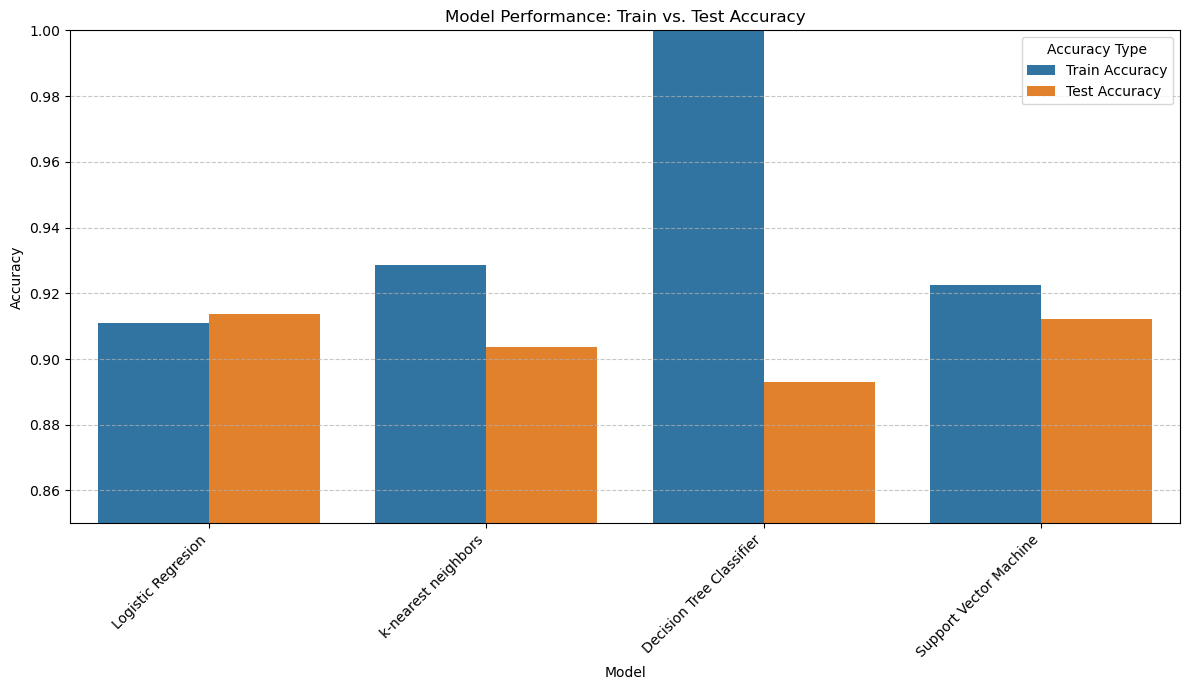

In [35]:
# Melt the DataFrame to have 'Metric' and 'Accuracy' columns for easier plotting
melted_df = df_model_comparison.melt(id_vars=['Model'], value_vars=['Train Accuracy', 'Test Accuracy'],
                                     var_name='Metric', value_name='Accuracy')

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Accuracy', hue='Metric', data=melted_df)
plt.ylim(0.85, 1.0) # Set a reasonable y-axis limit to highlight differences
plt.title('Model Performance: Train vs. Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accuracy Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [36]:
df_model_comparison

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regresion,0.110792,0.911069,0.913682
1,k-nearest neighbors,0.003224,0.928582,0.903606
2,Decision Tree Classifier,0.129920,1.000000,0.893044
3,Support Vector Machine,9.650125,0.922664,0.912104


#### Answer

From the Accuracy scores, I feel Logistic regression is a best model as it has good scores for Train and test data sets. Also the training time is much faster. 

The SVM model has marginally better Train Accurary, but test accuracy is lower and the Training time is significantly large 

Also, an interesting thing to note is the Decision Tree classifier model, seem to be overfitting with 100% training accuracy but lowest Test accuracy (almost the same as the basic always NO prediction model)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions